In [289]:
import torch
from torch import Tensor
from torch.distributions import Exponential
import numpy as np
import torch
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import random

In [290]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
#make dataset in dataframe - taken from learnpytorch.io

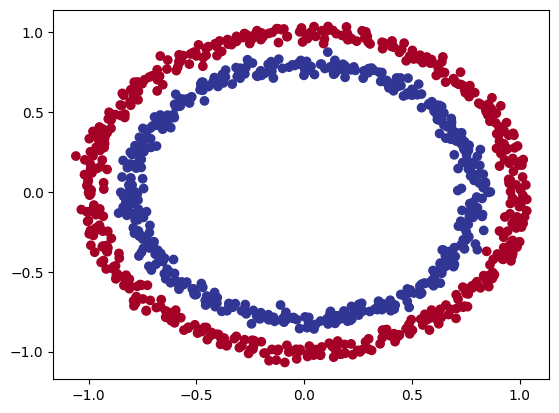

In [291]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

#dataset visualized - need to classify red vs blue circle

In [292]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [293]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [294]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [295]:
def sample_poisson_relaxed(lmbd, num_samples=100, temperature = 0.1):
    sampler = torch.empty(num_samples)
    z = Exponential(lmbd).rsample(sampler.size())
    t = torch.cumsum(z, 0)
    relaxed_indicator = torch.sigmoid((1.0 - t) / temperature)
    N = relaxed_indicator.sum()

    print(lmbd)
    print(N)
    return N

def poisson_activation(x):
    for i in range(x.size(dim=0)):
            for j in range(x.size(dim=1)):
                y = x[i][j].item()
            
                # print(y) 
                if y < 0:
                     x[i][j] = -sample_poisson_relaxed(-y)
                if y > 0:
                     x[i][j] = sample_poisson_relaxed(y)
                if y ==0:
                     x[i][j] = 0
    return(x)

def poisson_squared(x):
    for i in range(x.size(dim=0)):
          for j in range(x.size(dim=1)):
               y = x[i][j].item()
               
            
                # print(y) 
               if y ==0:
                    x[i][j] = 0
               else:
                    x[i][j] = sample_poisson_relaxed(y**2)
               
    return(x)

In [296]:

# def sample_poisson_relaxed(lmbd, num_samples=1000, temperature = 0.01):
#     sampler = torch.empty(num_samples)
#     z = Exponential(lmbd).rsample(sampler.size())
#     t = torch.cumsum(z, 0)
#     relaxed_indicator = torch.sigmoid((1.0 - t) / temperature)
#     N = relaxed_indicator.sum()
#     return N

from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=50) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=50, out_features=1) # takes in 5 features, produces 1 feature (y)
        # self.layer_4 = nn.Linear(in_features=10, out_features=1) # takes in 5 features, produces 1 feature (y)
        

    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        for i in range(x.size(dim=0)):
            for j in range(x.size(dim=1)):
                y = x[i][j]
                # print(y) 
                x[i][j] = y*10
        # print(x)
        layer1 = self.layer_1(x)
        # print(layer1)
        layer2 = self.layer_2(torch.relu(poisson_activation(layer1)))
        return layer2 # computation goes through layer_1 first then the output of layer_1 goes through layer_2

def makeModel():
    return CircleModelV0().to(device)
# 4. Create an instance of the model and send it to target device
# model_0 = CircleModelV0().to(device)
# model_0

In [297]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [298]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 20

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

noises = []
accuracy = []
finalaccuracy = []
finalnoise = []

# Build training and evaluation loop
# for x in range(10):
noise = 10**(-1*x)
print(noise)
model_0 = makeModel()
print(model_0)
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.01)
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                y_train) 
    acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    # noises.append(-x)
    # accuracy.append(acc)
    # finalaccuracy.append(acc)
    # finalnoise.append(-x)

1
CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=50, bias=True)
  (layer_2): Linear(in_features=50, out_features=1, bias=True)
)
Epoch: 0 | Loss: 0.86378, Accuracy: 48.38% | Test loss: 0.79646, Test acc: 50.50%


KeyboardInterrupt: 

In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


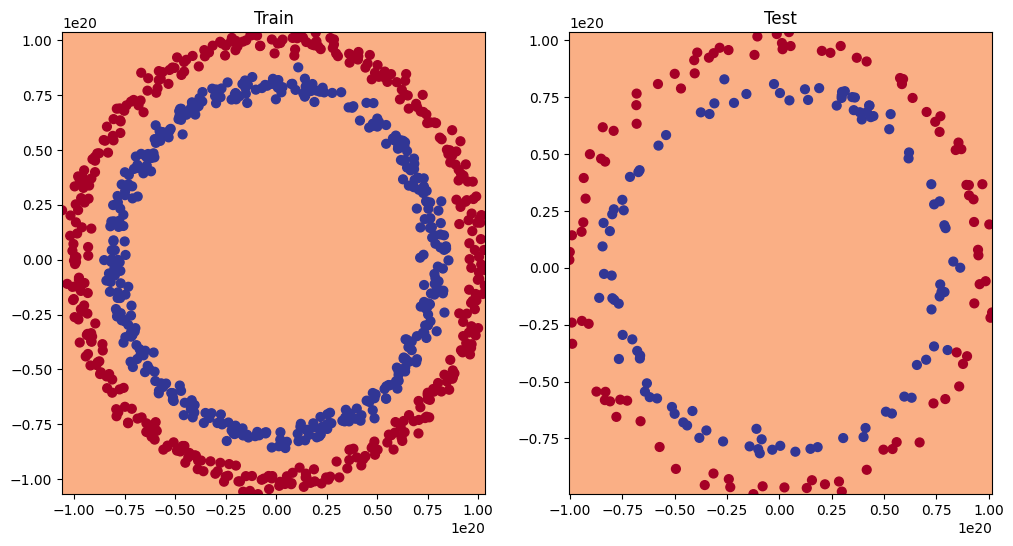

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)